In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore') # Pour masquer les avertissements de convergence

# Charger le jeu de données
file_path = '/content/heart_disease_uci.csv'
try:
    # Le paramètre na_values est ajouté car ce dataset utilise '?' pour les valeurs manquantes
    data = pd.read_csv(file_path, na_values='?')
    print("Données chargées avec succès à partir de :", file_path)
    # Remplacer la colonne 'num' par une colonne binaire 'output' (0 ou 1)
    # L'original 'num' est multi-classe (0 à 4). On le binarise : 0 = absence, >0 = présence.
    data['output'] = data['num'].apply(lambda x: 1 if x > 0 else 0)
    data = data.drop('num', axis=1) # Supprimer la colonne originale 'num'

except FileNotFoundError:
    print(f"Erreur : Le fichier {file_path} n'a pas été trouvé. Veuillez vérifier le chemin d'accès.")
    data = None

if data is not None:
    # Afficher les premières lignes
    print("\n--- Aperçu des données ---")
    print(data.head())

Données chargées avec succès à partir de : /content/heart_disease_uci.csv

--- Aperçu des données ---
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  output  
0       fixed defect       0  
1           

In [2]:
 #Étape 2 : Description des Données et Nettoyage (EDA Basique
if data is not None:
    print("\n--- Informations sur les données (Types et Non-Null) ---")
    data.info()

    print("\n--- Statistiques descriptives ---")
    print(data.describe(include='all'))

    print("\n--- Vérification des valeurs manquantes (après chargement) ---")
    print(data.isnull().sum())

    # Suppression des colonnes qui contiennent trop de NaN ou sont inutiles pour le modèle initial
    data = data.drop(columns=['id', 'dataset', 'fbs', 'restecg'], axis=1)
    # On impute les valeurs manquantes restantes (ca et thal) par la médiane/mode ou on supprime les lignes.
    # Pour un premier modèle, nous allons supprimer les lignes avec des NaN (seulement 6 lignes)
    data = data.dropna()

    print("\n--- Vérification des valeurs manquantes (après nettoyage) ---")
    print(data.isnull().sum())
    print(f"Taille du jeu de données après nettoyage : {len(data)}")

    # Vérification de la distribution de la variable cible
    print("\n--- Distribution de la variable cible ('output') ---")
    print(data['output'].value_counts())
    print(f"Pourcentage de maladie cardiaque (output=1): {(data['output'].sum() / len(data) * 100):.2f}%")


--- Informations sur les données (Types et Non-Null) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  output    920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

--- Statistiques descriptives ---
                id         age   sex

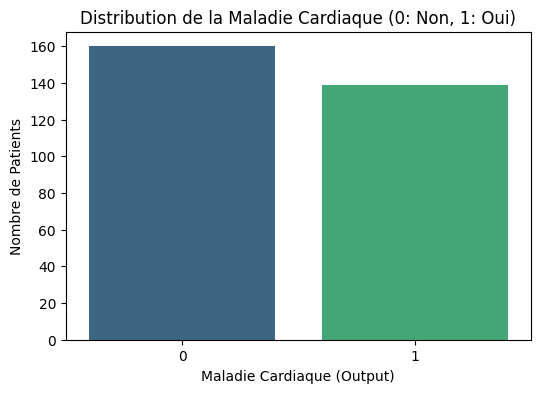

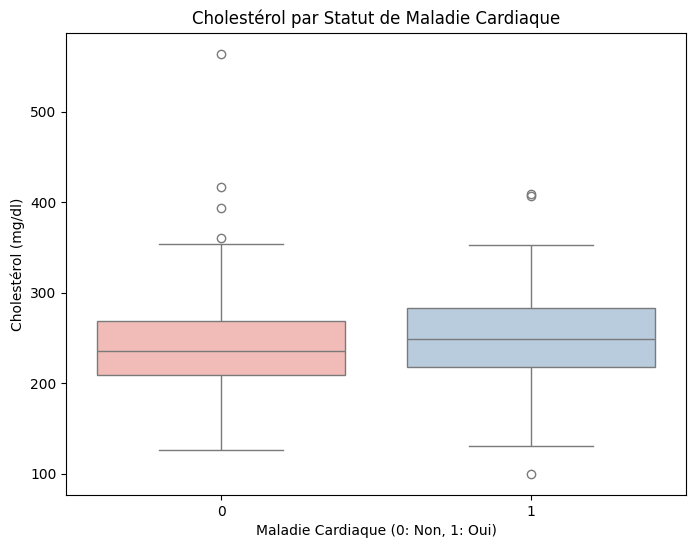

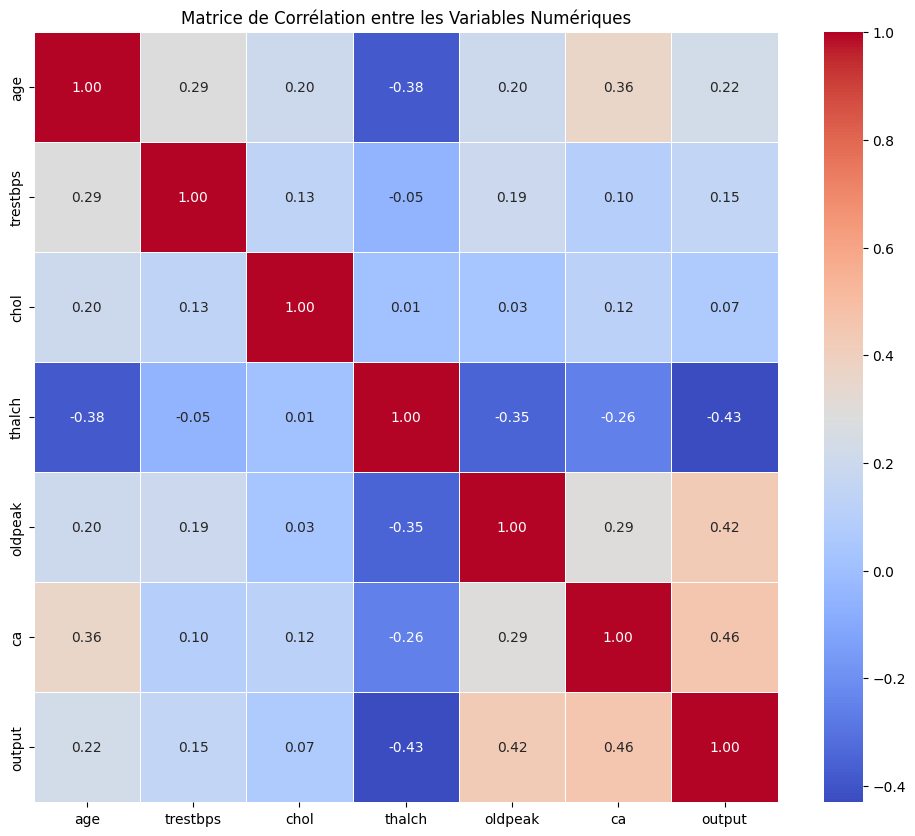

In [4]:
# Étape 3 : Analyse Exploratoire des Données (Visualisation)
if data is not None:
    # 3.1. Distribution de la variable cible
    plt.figure(figsize=(6, 4))
    sns.countplot(x='output', data=data, palette='viridis')
    plt.title('Distribution de la Maladie Cardiaque (0: Non, 1: Oui)')
    plt.xlabel('Maladie Cardiaque (Output)')
    plt.ylabel('Nombre de Patients')
    plt.show()

    # 3.2. Boxplot pour le Cholestérol vs la Maladie Cardiaque
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='output', y='chol', data=data, palette='Pastel1')
    plt.title('Cholestérol par Statut de Maladie Cardiaque')
    plt.xlabel('Maladie Cardiaque (0: Non, 1: Oui)')
    plt.ylabel('Cholestérol (mg/dl)')
    plt.show()

    # 3.3. Matrice de Corrélation
    numeric_cols = data.select_dtypes(include=np.number).columns
    corr_matrix = data[numeric_cols].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
    plt.title('Matrice de Corrélation entre les Variables Numériques')
    plt.show()

In [5]:
 #Pré-traitement pour la Modélisation
if data is not None:
    # Identifier les variables catégorielles qui doivent être encodées
    # sex, cp, thalach, exang, oldpeak, slope, ca, thal
    categorical_cols = ['sex', 'cp', 'exang', 'thal', 'ca', 'slope']

    # Convertir les colonnes en type 'category' si elles ne le sont pas
    for col in categorical_cols:
        if col in data.columns:
            data[col] = data[col].astype('category')

    # 4.1. One-Hot Encoding
    # Suppression de 'restecg' dans l'étape de nettoyage.
    data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

    # 4.2. Séparation des Caractéristiques (X) et de la Cible (y)
    X = data_encoded.drop('output', axis=1) # Caractéristiques
    y = data_encoded['output']              # Cible

    # 4.3. Séparation des jeux d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print("\n--- Dimensions des jeux de données après encodage et séparation ---")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")


--- Dimensions des jeux de données après encodage et séparation ---
X_train shape: (209, 17)
X_test shape: (90, 17)


Étape 5 : Modélisation (Régression Logistique)


In [7]:
if data is not None:
    # 5.1. Analyse Statistique Détaillée (Statsmodels)
    # Convertir les colonnes booléennes en entier (0 ou 1) pour la compatibilité avec statsmodels
    # X_train est dérivé de data_encoded, qui contient des colonnes booléennes issues de get_dummies.
    # Il est préférable de convertir ces colonnes booléennes en types entiers avant d'ajouter la constante
    # et de les alimenter à statsmodels.
    X_train_numeric = X_train.copy()
    for col in X_train_numeric.select_dtypes(include='bool').columns:
        X_train_numeric[col] = X_train_numeric[col].astype(int)

    # Ajouter une constante pour l'ordonnée à l'origine (intercept)
    X_train_sm = sm.add_constant(X_train_numeric)

    # Entraînement du modèle Logit (Logistic Regression) de statsmodels
    logit_model = sm.Logit(y_train, X_train_sm)
    result = logit_model.fit(disp=0)

    print("\n--- Résumé Statistique de la Régression Logistique (Statsmodels) ---")
    print(result.summary())

    # Interprétation : Calcul des Odds Ratios (exponentielle des coefficients)
    odds_ratios = np.exp(result.params)
    odds_ratios_df = pd.DataFrame({
        'Coefficient (Log-Odds)': result.params,
        'Odds Ratio (e^coef)': odds_ratios,
        'P-value': result.pvalues
    }).sort_values(by='P-value', ascending=True)

    print("\n--- Odds Ratios pour l'Interprétation des Facteurs (Ordonné par P-value) ---")
    print(odds_ratios_df)



--- Résumé Statistique de la Régression Logistique (Statsmodels) ---
                           Logit Regression Results                           
Dep. Variable:                 output   No. Observations:                  209
Model:                          Logit   Df Residuals:                      191
Method:                           MLE   Df Model:                           17
Date:                Fri, 12 Dec 2025   Pseudo R-squ.:                  0.5520
Time:                        16:54:02   Log-Likelihood:                -64.712
converged:                       True   LL-Null:                       -144.46
Covariance Type:            nonrobust   LLR p-value:                 3.333e-25
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.9944      3.440     -0.870      0.384      -9.737       3.748
age                      


--- Évaluation de la Performance (Scikit-learn) ---


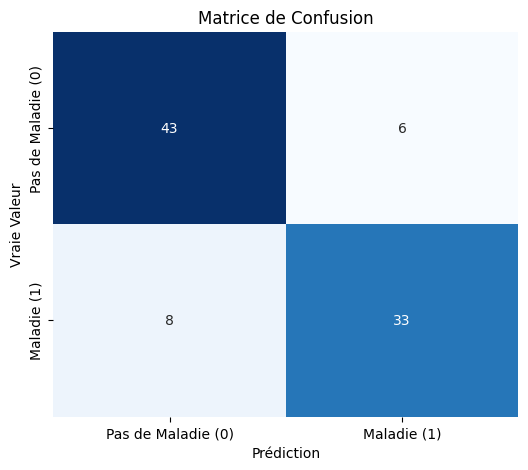


Rapport de Classification :
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        49
           1       0.85      0.80      0.82        41

    accuracy                           0.84        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.84      0.84      0.84        90

Précision (Accuracy) du modèle: 0.8444


In [8]:
if data is not None:
    # 5.2. Entraînement et évaluation (Scikit-learn)
    model_sk = LogisticRegression(max_iter=1000, random_state=42)
    model_sk.fit(X_train, y_train)
    y_pred = model_sk.predict(X_test)

    print("\n--- Évaluation de la Performance (Scikit-learn) ---")

    # Matrice de Confusion
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pas de Maladie (0)', 'Maladie (1)'],
                yticklabels=['Pas de Maladie (0)', 'Maladie (1)'])
    plt.title('Matrice de Confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie Valeur')
    plt.show()


    # Rapport de Classification
    print("\nRapport de Classification :")
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Précision (Accuracy) du modèle: {accuracy:.4f}")

In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ----------------------------------------------------------------------
# NOTE : Ce bloc suppose que les variables 'logit_model' et 'result'
# (issues de l'Étape 5.1 - Statsmodels) sont toujours disponibles en mémoire.
# Si vous exécutez ce code séparément, assurez-vous de réexécuter l'Étape 5.1.
# ----------------------------------------------------------------------

if 'result' in locals():
    # Calcul des Odds Ratios
    odds_ratios = np.exp(result.params)
    p_values = result.pvalues

    odds_ratios_df = pd.DataFrame({
        'Coefficient (Log-Odds)': result.params,
        'Odds Ratio (e^coef)': odds_ratios,
        'P-value': p_values
    })

    # Filtrer les variables jugées statistiquement significatives (P-value < 0.05)
    SIGNIFICANCE_LEVEL = 0.05
    significant_factors = odds_ratios_df[odds_ratios_df['P-value'] < SIGNIFICANCE_LEVEL].sort_values(by='Odds Ratio (e^coef)', ascending=False)

    print("##  Interprétation des Résultats de la Régression Logistique")
    print("\n--- Facteurs Statisquement Significatifs (P-value < 0.05) ---")

    if significant_factors.empty:
        print("Aucun facteur n'est statistiquement significatif au seuil de 0.05. Vérifiez le modèle.")
    else:
        # Afficher le tableau des facteurs significatifs
        # Arrondir pour la lisibilité
        print(significant_factors.round(4))

        print("\n--- Analyse de l'Impact (Odds Ratios) ---")
        print("Les Odds Ratios (OR) indiquent le changement des chances (odds) de maladie cardiaque.")
        print("\n**Facteurs Augmentant FORTEMENT les chances (OR >> 1) :**")
        # Identifier les facteurs dont l'OR est nettement supérieur à 1
        for index, row in significant_factors[significant_factors['Odds Ratio (e^coef)'] > 1.5].iterrows():
            # Interprétation de l'Odds Ratio : (OR - 1) * 100%
            increase_percent = (row['Odds Ratio (e^coef)'] - 1) * 100
            # Extract and format the odds ratio value separately to avoid potential f-string parsing issues
            formatted_odds_ratio_value = f"{row['Odds Ratio (e^coef)']:.2f}"
            print(f"* **{index}** : L'Odds Ratio est de {formatted_odds_ratio_value}. Cela signifie que l'augmentation de cette variable augmente les chances de maladie cardiaque d'environ **{increase_percent:.0f}%**.")

        print("\n**Facteurs Diminuant FORTEMENT les chances (OR << 1) :**")
        # Identifier les facteurs dont l'OR est nettement inférieur à 1
        for index, row in significant_factors[significant_factors['Odds Ratio (e^coef)'] < 0.67].iterrows(): # 0.67 est environ 1/1.5
            decrease_percent = (1 - row['Odds Ratio (e^coef)']) * 100
            # Extract and format the odds ratio value separately to avoid potential f-string parsing issues
            formatted_odds_ratio_value = f"{row['Odds Ratio (e^coef)']:.2f}"
            print(f"* **{index}** : L'Odds Ratio est de {formatted_odds_ratio_value}. Cela signifie que l'augmentation de cette variable diminue les chances de maladie cardiaque d'environ **{decrease_percent:.0f}%**.")



##  Interprétation des Résultats de la Régression Logistique

--- Facteurs Statisquement Significatifs (P-value < 0.05) ---
                   Coefficient (Log-Odds)  Odds Ratio (e^coef)  P-value
ca_2.0                             2.9218              18.5744   0.0006
ca_1.0                             2.0860               8.0524   0.0006
ca_3.0                             2.0710               7.9331   0.0352
sex_Male                           1.7584               5.8033   0.0087
cp_typical angina                 -1.8708               0.1540   0.0157
cp_non-anginal                    -2.3047               0.0998   0.0002

--- Analyse de l'Impact (Odds Ratios) ---
Les Odds Ratios (OR) indiquent le changement des chances (odds) de maladie cardiaque.

**Facteurs Augmentant FORTEMENT les chances (OR >> 1) :**
* **ca_2.0** : L'Odds Ratio est de 18.57. Cela signifie que l'augmentation de cette variable augmente les chances de maladie cardiaque d'environ **1757%**.
* **ca_1.0** : L'Odds Ratio 